In [ ]:
# importing all the things we need further down
import platform
from pathlib import Path

import matplotlib.pyplot as plt
from careamics.lightning import VAEModule
from pytorch_lightning import Trainer
from torch.utils.data import DataLoader

from microsplit_reproducibility.configs.factory import (
    create_algorithm_config,
    get_likelihood_config,
    get_loss_config,
    get_model_config,
    get_optimizer_config,
    get_training_config,
    get_lr_scheduler_config,
)
from microsplit_reproducibility.utils.callbacks import get_callbacks
from microsplit_reproducibility.datasets import create_train_val_datasets
from microsplit_reproducibility.utils.utils import plot_input_patches

# Dataset specific imports...
from microsplit_reproducibility.configs.parameters.custom_dataset_2D import (
    get_microsplit_parameters
)
from microsplit_reproducibility.configs.data.custom_dataset_2D import get_data_configs
from microsplit_reproducibility.datasets.custom_dataset_2D import get_train_val_data

### Load example data

In [ ]:
# DATA = pooch.create(
#     path=f"./data/",
#     base_url=f"https://download.fht.org/jug/msplit/ht_lif24/data_tiff/",
#     registry={f"ht_lif24_5ms_reduced.zip": None},
# )
# for fname in DATA.registry:
#     DATA.fetch(fname, processor=pooch.Unzip(), progressbar=True)

# DATA_PATH = DATA.abspath / (DATA.registry_files[0] + ".unzip/5ms/data/")

### OR set the path to your own data
Important: the path should end with `data/`

In [4]:
RESULTS_ROOT = Path("/group/jug/aman/Datasets/HAGEN/")
DATA_PATH = RESULTS_ROOT/ "data"

### Setup the path to the noise models
This is the path to the noise models that you trained in the notebook **00_noisemodels.ipynb**

In [5]:
NM_PATH = RESULTS_ROOT/"noise_models"

### Next, we load the image data to be processed

***Note*** that depending on the amount of GPU memory you have available, you might want to adjust the batch size. The default is 32, but you can reduce it to 16 if you run out of memory by changing the <i> batch_size </i> parameter in <i> get_microsplit_parameters </i> below.

Number of epochs is set to 10, which usually allows to see decent results. However, for getting optimal performance you can increase it to 50.

You also need to change the `num_channels` and `target_channels` parameters respectively for the `get_data_configs()` and the `get_microsplit_parameters` functions. These parameters have a similar meaning, i.e., they control the number of channels in the input data depending on how many channels you want to split.

Finally, ensure that the `image_size` parameter (i.e., the patch size in (`Z`, `Y`, `X`) you want to use to train the model) is properly set given the size of your data and of you GPU.

In [6]:
NUM_CHANNELS = 2
"""The number of channels considered for the splitting task."""
BATCH_SIZE = 64
"""The batch size for training."""
PATCH_SIZE = (64, 64)
"""The size of the patches fed to the network for training in (Y, X)."""
EPOCHS = 50
"""The number of epochs to train the network."""

assert len(PATCH_SIZE) == 2, "PATCH_SIZE must be a tuple of length 2 (Y, X) since we are using 2D data."

In [7]:
# setting up train, validation, and test data configs
train_data_config, val_data_config, test_data_config = get_data_configs(
    image_size=PATCH_SIZE,
    num_channels=NUM_CHANNELS
)

# setting up MicroSplit parametrization
experiment_params = get_microsplit_parameters(
    algorithm="denoisplit",
    img_size=PATCH_SIZE,
    batch_size=BATCH_SIZE,
    num_epochs=EPOCHS,
    multiscale_count=3,
    noise_model_path=NM_PATH,
    target_channels=NUM_CHANNELS,
)

# create the dataset
train_dset, val_dset, test_dset, data_stats = create_train_val_datasets(
    datapath=DATA_PATH,
    train_config=train_data_config,
    val_config=val_data_config,
    test_config=val_data_config,
    load_data_func=get_train_val_data,
)


Padding is not used with this alignement style

Padding is not used with this alignement style

Padding is not used with this alignement style


### Configure `num_workers`
In Windows and MacOS, setting `num_workers > 0` for dataloaders would cause out-of-memory issue and might crash the system.

In [8]:
def get_num_workers():
    """Utility function to set num_workers based on OS."""
    if platform.system() == "Windows" or platform.system() == "Darwin":
        return 0
    else:
        return 3  # or any other number suitable for your system

experiment_params["num_workers"] = get_num_workers()

***Optional:*** inspect data configurations and <nobr>Micro$\mathbb{S}$plit</nobr> config

In [9]:
do_show_configs = True

if do_show_configs:
    print("FYI: train_data_config")
    print("----------------------")
    for cfg in train_data_config:
        print(cfg)

    print("\nFYI: experiment_params")
    print("----------------------")
    print(experiment_params)
else:
    print("You opted out of having all params printed... swiftly moving on... ;)")

FYI: train_data_config
----------------------
('data_type', <DataType.HTLIF24Data: 1>)
('depth3D', 1)
('datasplit_type', <DataSplitType.Train: 1>)
('num_channels', 2)
('ch1_fname', None)
('ch2_fname', None)
('ch_input_fname', None)
('input_is_sum', False)
('input_idx', None)
('target_idx_list', None)
('start_alpha', None)
('end_alpha', None)
('image_size', (64, 64))
('grid_size', 64)
('empty_patch_replacement_enabled', False)
('empty_patch_replacement_channel_idx', None)
('empty_patch_replacement_probab', None)
('empty_patch_max_val_threshold', None)
('uncorrelated_channels', False)
('uncorrelated_channel_probab', 0.5)
('poisson_noise_factor', -1.0)
('synthetic_gaussian_scale', 100.0)
('input_has_dependant_noise', True)
('enable_gaussian_noise', False)
('allow_generation', False)
('training_validtarget_fraction', None)
('deterministic_grid', None)
('enable_rotation_aug', False)
('max_val', None)
('overlapping_padding_kwargs', {'mode': 'reflect'})
('print_vars', False)
('normalized_inpu

### Final step: create Dataloaders for network training

In [10]:
train_dloader = DataLoader(
    train_dset,
    batch_size=experiment_params["batch_size"],
    num_workers=experiment_params["num_workers"],
    shuffle=True,
)
val_dloader = DataLoader(
    val_dset,
    batch_size=experiment_params["batch_size"],
    num_workers=experiment_params["num_workers"],
    shuffle=False,
)

# **Step 1.2:** Prepare <nobr>Micro$\mathbb{S}$plit</nobr> Training
Next, we create all the configs for the upcoming network training run. These lines are not very intuitive and if you don't intend to dive really deep into CAREamics and the internals of <nobr>Micro$\mathbb{S}$plit</nobr>, you might just execute these cells and move on.

In [11]:
# making our data_stas known to the experiment we prepare
experiment_params["data_stats"] = data_stats

# setting up training losses and model config (using default parameters)
loss_config = get_loss_config(**experiment_params)
model_config = get_model_config(**experiment_params)
gaussian_lik_config, noise_model_config, nm_lik_config = get_likelihood_config(
    **experiment_params
)
training_config = get_training_config(**experiment_params)

# setting up learning rate scheduler and optimizer (using default parameters)
lr_scheduler_config = get_lr_scheduler_config(**experiment_params)
optimizer_config = get_optimizer_config(**experiment_params)

# finally, assemble the full set of experiment configurations...
experiment_config = create_algorithm_config(
    algorithm=experiment_params["algorithm"],
    loss_config=loss_config,
    model_config=model_config,
    gaussian_lik_config=gaussian_lik_config,
    nm_config=noise_model_config,
    nm_lik_config=nm_lik_config,
    lr_scheduler_config=lr_scheduler_config,
    optimizer_config=optimizer_config,
)

/home/aman.kukde/sliding_windowed_tiling/microsplit/careamics/src/careamics/utils/serializers.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(lst)


## Initialize the <nobr>Micro$\mathbb{S}$plit</nobr> model to be trained..

In [12]:
model = VAEModule(algorithm_config=experiment_config)

[GaussianMixtureNoiseModel] min_sigma: 200.0
[GaussianMixtureNoiseModel] min_sigma: 200.0
[MultiChannelNoiseModel] Nmodels count:2
[GaussianLikelihood] PredLVar:pixelwise LowBLVar:-5.0


### *Load checkpoint (optional and for you to implement)*

<div class="alert alert-block alert-success">
<b>Note:</b> If you would like to continue a previous training run or finetune a compatible pre-trained model, here would be a good place. You will need to figure out how to implement this for your use-case, but to give you a head-start, we left three potentially useful lines of code below.
</div>

In [13]:
# from microsplit_reproducibility.notebook_utils.HT_LIF24 import load_pretrained_model
# ckpt_path = load_checkpoint_path(f"./pretrained_checkpoints/{EXPOSURE_DURATION}/", best=True)
# load_pretrained_model(model, ckpt_path)

## Show some training data for a final check!
***Tip:*** we show you a few samples of the prepared training data. In case you don't like what you see, execute the cell again and other randomly chosen patches will be shown!

[9665, 18454, 64948]

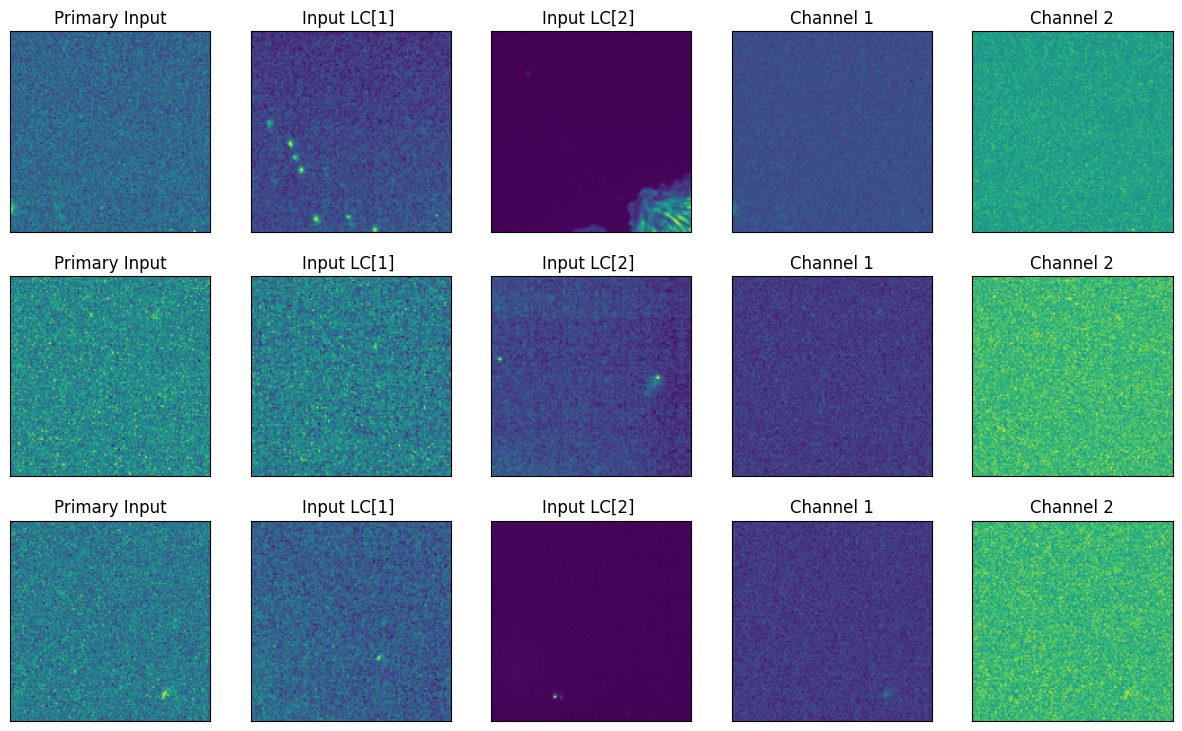

In [14]:
plot_input_patches(dataset=train_dset, num_channels=NUM_CHANNELS, num_samples=3, patch_size=128)

# **Step 1.3:** Train the prepared model!
***Note:*** if this takes too long, there were to places above where we gave you options to *(i)* reduce the amount of training data, and *(ii)* chose to train for fewer epochs. Revisit your choices if you want to!

***Note:*** Depending on the amount of GPU memory you have available, you might want to adjust the batch size. The default is 32, but you can reduce it to 16 if you run out of memory by changing the <i> batch_size </i> parameter in <i> get_microsplit_parameters </i> above.


In [ ]:
# create the Trainer
trainer = Trainer(
    max_epochs=training_config.num_epochs,
    accelerator="gpu",
    enable_progress_bar=True,
    callbacks=get_callbacks(RESULTS_ROOT/"checkpoints/"),
    precision=training_config.precision,
    gradient_clip_val=training_config.gradient_clip_val,
    gradient_clip_algorithm=training_config.gradient_clip_algorithm,
)
# start the training
trainer.fit(
    model=model,
    train_dataloaders=train_dloader,
    val_dataloaders=val_dloader,
)

# **Step 1.4:** Predict and visualize results for validation data...

In [ ]:
# Optional, reduce the validation dataset to speed up the evaluation
val_dset.reduce_data([0])

***Note*** Parameter `mmse_count` is responsible for how many samples are generated for each patch. The default value is 1, but in this case you might see stitching artifacts because each patch will be slightly different. You can increase this value to 10 to get a smoother image

In [ ]:
from microsplit_reproducibility.notebook_utils.custom_dataset_2D import (
    get_unnormalized_predictions,
    get_target,
    get_input,
)

stitched_predictions, _, _ = get_unnormalized_predictions(
    model,
    test_dset,
    data_key=val_dset._fpath.name,
    mmse_count=experiment_params['mmse_count'],
    num_workers=0,
    batch_size=8
)
tar = get_target(test_dset)

# get input as sum of the two channels
inp = get_input(test_dset).sum(-1)

In [ ]:
import numpy as np
import dill
save_dir = RESULTS_ROOT/'predictions'
save_dir.mkdir(parents=True, exist_ok=True)
# saving the predictions as a tiff file
stitched_preds_np = np.array(stitched_predictions)
print("Shape before squeeze:", stitched_preds_np.shape)

with open(save_dir / "pred_test_dset_microsplit_og.pkl", "wb") as f:
    dill.dump(stitched_preds_np, f)



## Overview: visualize predictions on validation data...

In [ ]:
_, ax = plt.subplots(2, 2, figsize=(20, 20))
ax[0, 0].imshow(tar[0, ..., 0], cmap="gray")
ax[0, 0].set_title("Input ch1")
ax[0, 1].imshow(tar[0, ..., 1], cmap="gray")
ax[0, 1].set_title("Input ch2")
ax[1, 0].imshow(stitched_predictions[0, ..., 0], cmap="gray")
ax[1, 0].set_title("Prediction ch1")
ax[1, 1].imshow(stitched_predictions[0, ..., 1], cmap="gray")
ax[1, 1].set_title("Prediction ch2")

In [ ]:
from microsplit_reproducibility.notebook_utils.custom_dataset_2D import full_frame_evaluation

frame_idx = 0
assert frame_idx < len(stitched_predictions), f"Frame index {frame_idx} out of bounds"
full_frame_evaluation(stitched_predictions[frame_idx], tar[frame_idx], inp[frame_idx])

## Detailed view on some (foreground) locations...
Below, we show few random foreground locations and the corresponding <nobr>Micro$\mathbb{S}$plit</nobr> predictions.

As before, also here you can execute the cell multiple times and different randomly chosen locations will be plotted.

In [ ]:
import numpy as np
from microsplit_reproducibility.utils.utils import clean_ax
from microsplit_reproducibility.notebook_utils.custom_dataset_2D import (
    pick_random_patches_with_content,
)
import matplotlib.pyplot as plt

img_sz = 128
rand_locations = pick_random_patches_with_content(tar, 128)
h_start = rand_locations[
    2, 0
]  # np.random.randint(stitched_predictions.shape[1] - img_sz)
w_start = rand_locations[
    2, 1
]  # np.random.randint(stitched_predictions.shape[2] - img_sz)

ncols = 4 + 1
nrows = min(len(rand_locations), 5)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 3, nrows * 3))

for i, (h_start, w_start) in enumerate(rand_locations[:nrows]):
    ax[i, 0].imshow(inp[0, h_start : h_start + img_sz, w_start : w_start + img_sz])
    for j in range(ncols // 2):
        vmin = stitched_predictions[
            0, h_start : h_start + img_sz, w_start : w_start + img_sz, j
        ].min()
        vmax = stitched_predictions[
            0, h_start : h_start + img_sz, w_start : w_start + img_sz, j
        ].max()
        ax[i, 2 * j + 1].imshow(
            tar[0, h_start : h_start + img_sz, w_start : w_start + img_sz, j],
            vmin=vmin,
            vmax=vmax,
        )
        ax[i, 2 * j + 2].imshow(
            stitched_predictions[
                0, h_start : h_start + img_sz, w_start : w_start + img_sz, j
            ],
            vmin=vmin,
            vmax=vmax,
        )

ax[0, 0].set_title("Primary Input")
for i in range(2):
    ax[0, 2 * i + 1].set_title(f"Target Channel {i+1}")
    ax[0, 2 * i + 2].set_title(f"Predicted Channel {i+1}")

# reduce the spacing between the subplots
plt.subplots_adjust(wspace=0.03, hspace=0.03)
clean_ax(ax)

## *Optional:* manual inspection of the predictions
<div class="alert alert-block alert-info">
<b> Task:</b> Set <i>y_start</i>, <i>x_start</i>, and <i>crop_size</i> to inspect the predictions at a  location of your choice.
</div>

In [ ]:
import numpy as np

y_start = 600  # np.random.randint(stitched_predictions.shape[1] - crop_size)
x_start = 1150  # np.random.randint(stitched_predictions.shape[2] - crop_size)
crop_size = 128

ncols = 3
nrows = 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5))
ax[0, 0].imshow(inp[0, y_start : y_start + crop_size, x_start : x_start + crop_size])
for i in range(ncols - 1):
    vmin = stitched_predictions[
        0, y_start : y_start + crop_size, x_start : x_start + crop_size, i
    ].min()
    vmax = stitched_predictions[
        0, y_start : y_start + crop_size, x_start : x_start + crop_size, i
    ].max()
    ax[0, i + 1].imshow(
        tar[0, y_start : y_start + crop_size, x_start : x_start + crop_size, i],
        vmin=vmin,
        vmax=vmax,
    )
    ax[1, i + 1].imshow(
        stitched_predictions[
            0, y_start : y_start + crop_size, x_start : x_start + crop_size, i
        ],
        vmin=vmin,
        vmax=vmax,
    )

# disable the axis for ax[1,0]
ax[1, 0].axis("off")
ax[0, 0].set_title("Input")
ax[0, 1].set_title("Channel 1")
ax[0, 2].set_title("Channel 2")
# set y labels on the right for ax[0,2]
ax[0, 2].yaxis.set_label_position("right")
ax[0, 2].set_ylabel("Target")

ax[1, 2].yaxis.set_label_position("right")
ax[1, 2].set_ylabel("Predicted")

print("Here the crop you selected:")

# ***Optional Step 1.4:*** Posterior Sampling
For a given input patch, <nobr>Micro$\mathbb{S}$plit</nobr> can generate multiple outputs. This is possible because <nobr>Micro$\mathbb{S}$plit</nobr> is learning a full posterior of possible solutions, which is a quite powerful feature!

As we elaborate in the <nobr>Micro$\mathbb{S}$plit</nobr> paper and also later in the calibration notebook `03_calibration.ipynb`, this allows users to visually judge and even quantify the (data) uncertainty in the predictions their trained model makes.

Below, we show two posterior samples and how much they differ for a few random foreground locations. Re-run the cell to see different randomly choosen locations and corresponding posterior samples.

In [ ]:
from microsplit_reproducibility.notebook_utils.custom_dataset_2D import show_sampling

imgsz = 3
ncols = 6
examplecount = 3
_, ax = plt.subplots(
    figsize=(imgsz * ncols, imgsz * 2 * examplecount),
    ncols=ncols,
    nrows=2 * examplecount,
)

show_sampling(val_dset, model, ax=ax[:2])
show_sampling(val_dset, model, ax=ax[2:4])
show_sampling(val_dset, model, ax=ax[4:6])
plt.tight_layout()

### You are done here! 👍 Congratulations! 🎉